# Predicting Airbnb prices with k-nearest neighbours

### Intro

In this Notebook we show how to build a k-nearest predictor for Airbnb listing given a set of parameters.

### Getting the data

We use data from http://insideairbnb.com/get-the-data.html. For each city of interest, the user is requested to download the listings.csv.gz file and to unzip it as CITYNAME_listings.csv .

### Predicting the price of single listings

We run the following code to predict the price of a single listing. The user may select city and features of the listing.

In [3]:
import pandas as pd
import numpy as np
from scipy.spatial import distance
import sys
import json

columns = ["price", "room_type", "accommodates", "bedrooms", "bathrooms", "beds", "number_of_reviews", "latitude", "longitude", "review_scores_rating"]

#load cities' information
with open('cities_dictionary.json') as json_data:
    cities_dict = json.load(json_data)

#choose the city
city = "ATHENS"

#upload data
try:
    city_listings = pd.read_csv("DATA/raw/" + city + "_listings.csv")
except Exception:
    if city == "HONG KONG":
        city = "HK"
        city_listings = pd.read_csv("DATA/raw/" + city + "_listings.csv")
        city = "HONG KONG"
    if city == "LOS ANGELES":
        city = "LA"
        city_listings = pd.read_csv("DATA/raw/" + city + "_listings.csv")
        city = "LOS ANGELES"
    if city == "SAN FRANCISCO":
        city = "SF"
        city_listings = pd.read_csv("DATA/raw/" + city + "_listings.csv")
        city = "SAN FRANCISCO"

#select relevant columns from the data
city_listings = city_listings[columns]

#drop room types that are not well formatted
TF = (city_listings["room_type"] == "Entire home/apt") | (city_listings["room_type"] == "Private room")
city_listings = city_listings[TF]
#drop NaN rows, which means we mostly drop items which have no reviews
city_listings = city_listings.dropna()
#shuffle
city_listings = city_listings.sample(frac=1,random_state=0)
#remove unwanted sharacters
city_listings['price'] = city_listings.price.str.replace("\$|,",'').astype(float)
#set private room type to 0 and entire home/apt to 1
city_listings['room_type'].replace("Private room", 0.0,inplace=True)
city_listings['room_type'].replace("Entire home/apt", 1.0,inplace=True)
#we normalise
for items in columns[1:]:
    mean = city_listings[items].mean()
    std = np.std(city_listings[items])
    N_items = "N_"+items
    city_listings[N_items] = (city_listings[items] - mean) / std

N_columns = ["price", "N_room_type", "N_accommodates", "N_bedrooms", "N_bathrooms", "N_beds", "N_number_of_reviews", "N_latitude", "N_longitude", "N_review_scores_rating"]

#drop old columns
normal_city_listings = city_listings[N_columns]


my_property = {"room_type": [0.0,],"accommodates": [2.0,], "bedrooms": [1.0,], "bathrooms": [1.0,], "beds": [1.0,], "number_of_reviews": [135.0,], "latitude": [37.98463566,], "longitude": [23.7370348,], "review_scores_rating": [95.0,]}

#"latitude": [37.98463566,], "longitude": [23.7370348,]

my_property_df = pd.DataFrame(my_property)

#will need this later on to get real latitude and longitude
long_avg = city_listings["longitude"].mean()
long_std = np.std(city_listings["longitude"])
lat_avg =city_listings["latitude"].mean()
lat_std =np.std(city_listings["latitude"])

#normalise columns
for items in columns[1:]:
    mean = city_listings[items].mean()
    N_items = "N_"+items
    std = np.std(city_listings[items])
    my_property_df[N_items] = (my_property_df[items] - mean) / std

#drop original-value columns
N_my_property_df=my_property_df[N_columns[1:]]


#choose columns you want to take into account for the purpose of calculating the price
feature_cols = ["N_room_type", "N_accommodates", "N_bedrooms", "N_bathrooms", "N_beds", "N_number_of_reviews", "N_review_scores_rating", "N_latitude", "N_longitude"]


def predict_price_multivariate(row, test_item):
    distance_series = distance.euclidean(test_item, row)
    return(distance_series)


N_my_property_df = N_my_property_df[feature_cols]
selected_normal_city_listings = normal_city_listings[feature_cols]

distance_series = selected_normal_city_listings.apply(predict_price_multivariate, test_item=N_my_property_df, axis=1) 

#print(distance_series)

normal_city_listings = normal_city_listings.assign(distance=distance_series)

normal_city_listings.sort_values("distance", inplace=True)

if "N_longitude" in feature_cols and "N_latitude" in feature_cols:
    normal_city_listings["longitude"] = (normal_city_listings["N_longitude"]*long_std)+long_avg
    normal_city_listings["latitude"] = (normal_city_listings["N_latitude"]*lat_std)+lat_avg

#set parameter for k-nearest
k = 6

knn = normal_city_listings.iloc[:k]
print "The 5-nearest neighbours are:"
print
print knn

predicted_price = knn["price"].mean()

#adjust for the conversion rate
predicted_price = int(round(predicted_price*cities_dict[city][0]))

print
print "The price for a 1 night stay in", city, "is", predicted_price, "euro."
print "In 1 month a host in", city, "typically makes", int(round(predicted_price*30*cities_dict[city][1])), "euro."
print "Monthly rent in", city, "is typically", int(round(cities_dict[city][2])),"euro."

The 5-nearest neighbours are:

      price  N_room_type  N_accommodates  N_bedrooms  N_bathrooms    N_beds  \
1385   17.0    -2.452462       -0.865858    -0.43062    -0.378106 -0.765038   
1759   17.0    -2.452462       -1.370690    -0.43062    -0.378106 -0.765038   
1538   46.0    -2.452462       -0.865858    -0.43062    -0.378106 -0.765038   
3514   19.0    -2.452462       -0.865858    -0.43062     0.730870 -0.765038   
3564   15.0    -2.452462       -0.865858    -0.43062    -0.378106 -0.765038   
3259   22.0    -2.452462       -0.865858    -0.43062    -0.378106 -0.765038   

      N_number_of_reviews  N_latitude  N_longitude  N_review_scores_rating  \
1385             1.697863   -0.206346    -0.276110               -0.044552   
1759             2.144497   -0.302799    -0.227574                0.367543   
1538             2.792116   -0.312514    -0.250984                0.504908   
3514             2.256155    0.471189     0.101864                0.092813   
3564             1.117239

The algorithm predicts a price of 23 euro for a single room for two in the Exarhia district, which is just 1 euro off its real price.

### Evaluating the model

We split our data into 3/4 vs. 1/4 shares. We use the first as train set and the latter as test set. We predict prices for all listings in the test set and we compare it to the real price.

In [5]:
import pandas as pd
import numpy as np
from scipy.spatial import distance
import sys
import json
import math

columns = ["price", "room_type", "accommodates", "bedrooms", "bathrooms", "beds", "number_of_reviews", "latitude", "longitude", "review_scores_value"]

#load cities' information
with open('cities_dictionary.json') as json_data:
    cities_dict = json.load(json_data)

del cities_dict['EXAMPLE']

#choose the city
city = "AMSTERDAM"

#upload data
try:
    city_listings = pd.read_csv("DATA/raw/" + city + "_listings.csv")
except Exception:
    if city == "HONG KONG":
        city = "HK"
        city_listings = pd.read_csv("DATA/raw/" + city + "_listings.csv")
        city = "HONG KONG"
    if city == "LOS ANGELES":
        city = "LA"
        city_listings = pd.read_csv("DATA/raw/" + city + "_listings.csv")
        city = "LOS ANGELES"
    if city == "SAN FRANCISCO":
        city = "SF"
        city_listings = pd.read_csv("DATA/raw/" + city + "_listings.csv")
        city = "SAN FRANCISCO"

#select relevant columns from the data
city_listings = city_listings[columns]

#drop room types that are not well formatted
TF = (city_listings["room_type"] == "Entire home/apt") | (city_listings["room_type"] == "Private room")
city_listings = city_listings[TF]
#drop NaN rows, which means we mostly drop items which have no reviews
city_listings = city_listings.dropna()
#shuffle
city_listings = city_listings.sample(frac=1,random_state=0)

#remove unwanted sharacters
city_listings['price'] = city_listings.price.str.replace("\$|,",'').astype(float)
#set private room type to 0 and entire home/apt to 1
city_listings['room_type'].replace("Private room", 0.0,inplace=True)
city_listings['room_type'].replace("Entire home/apt", 1.0,inplace=True)

mean_price = city_listings["price"].mean()

split_value = int(round(float(city_listings.shape[0])*75/100))

#we use 75% of the dataset as train, 25% as test
train_set = city_listings.iloc[:split_value]
test_set = city_listings.iloc[split_value:]

#we normalise
for items in columns[1:]:
    mean = city_listings[items].mean()
    std = np.std(city_listings[items])
    N_items = "N_"+items
    city_listings[N_items] = (city_listings[items] - mean) / std

N_columns = ["price", "N_room_type", "N_accommodates", "N_bedrooms", "N_bathrooms", "N_beds", "N_number_of_reviews", "N_latitude", "N_longitude", "N_review_scores_value"]

#drop old columns
normal_city_listings = city_listings[N_columns]

train_set = normal_city_listings.iloc[:2888]
test_set = normal_city_listings.iloc[2888:]


#choose columns you want to take into account for the purpose of calculating the price
feature_cols = ["N_room_type", "N_accommodates", "N_bedrooms", "N_bathrooms", "N_beds", "N_latitude", "N_longitude", "N_review_scores_value", "N_number_of_reviews"]

train_set_f = train_set[feature_cols]
test_set_f = test_set[feature_cols]

standard_deviation = 0

k = 5

aces = 0

differences_squared = []

precision = 0.30

for index, rows in test_set_f.iterrows():

    distance_series = train_set_f.apply(lambda row: distance.euclidean(rows, row), axis=1) 

    train_set = train_set.assign(distance=distance_series)

    train_set.sort_values("distance", inplace=True)

    knn = train_set.iloc[:k]

    predicted_price = knn["price"].mean()
    predicted_price = predicted_price.item()

    real_price = test_set.loc[[index], :]["price"]
    real_price = real_price.item()

    differences_squared.append((predicted_price - real_price)**2)

    if predicted_price/real_price < 1 + precision and predicted_price/real_price > 1 - precision:
        aces += 1
    del train_set["distance"]

average_deviation  = sum(differences_squared) / float(len(differences_squared))
rmse = (average_deviation)**0.5
print
print "Rmse: ", rmse, "for a price mean: ", mean_price
acespercent = float(aces)/float(test_set.shape[0])
print "Accuracy %:", acespercent, "with a precision: ", precision



Rmse:  57.9079032562 for a price mean:  132.71196675
Accuracy %: 0.659266017843 with a precision:  0.3


Within our multivariate model, we study the relative weigh of each parameter in determining the 5-nearest neighbours.

In [6]:
import pandas as pd
import numpy as np
from scipy.spatial import distance
import sys
import json
import seaborn as sns
import matplotlib.pyplot as plt

columns = ["price", "room_type", "accommodates", "bedrooms", "bathrooms", "beds", "number_of_reviews", "review_scores_value"]

#load cities' information
with open('cities_dictionary.json') as json_data:
    cities_dict = json.load(json_data)

del cities_dict['EXAMPLE']

city_list = []
for key in cities_dict:
    city_list.append(key)
print city_list

heat_dict = {}

for city in city_list:

    #upload data
    try:
        city_listings = pd.read_csv("DATA/raw/" + city + "_listings.csv")
    except Exception:
        if city == "HONG KONG":
            city = "HK"
            city_listings = pd.read_csv("DATA/raw/" + city + "_listings.csv")
            city = "HONG KONG"
        if city == "LOS ANGELES":
            city = "LA"
            city_listings = pd.read_csv("DATA/raw/" + city + "_listings.csv")
            city = "LOS ANGELES"
        if city == "SAN FRANCISCO":
            city = "SF"
            city_listings = pd.read_csv("DATA/raw/" + city + "_listings.csv")
            city = "SAN FRANCISCO"


    #select relevant columns from the data
    city_listings = city_listings[columns]

    #number reviews mean
    reviews_mean = float(city_listings["number_of_reviews"].mean())

    #average review score
    score_mean = float(city_listings["review_scores_value"].mean())

    #drop room types that are not well formatted
    TF = (city_listings["room_type"] == "Entire home/apt") | (city_listings["room_type"] == "Private room")
    city_listings = city_listings[TF]
    #drop NaN rows, which means we mostly drop items which have no reviews
    city_listings = city_listings.dropna()
    #shuffle
    city_listings = city_listings.sample(frac=1,random_state=0)
    #remove unwanted sharacters
    city_listings['price'] = city_listings.price.str.replace("\$|,",'').astype(float)
    #set private room type to 0 and entire home/apt to 1
    city_listings['room_type'].replace("Private room", 0.0,inplace=True)
    city_listings['room_type'].replace("Entire home/apt", 1.0,inplace=True)

    #we normalise
    for items in columns[1:]:
        mean = city_listings[items].mean()
        std = np.std(city_listings[items])
        N_items = "N_"+items
        city_listings[N_items] = (city_listings[items] - mean) / std

    N_columns = ["price", "N_room_type", "N_accommodates", "N_bedrooms", "N_bathrooms", "N_beds", "N_number_of_reviews", "N_review_scores_value"]

    #drop old columns
    normal_city_listings = city_listings[N_columns]


    my_property = {"room_type": [1.0,],"accommodates": [2.0,], "bedrooms": [1.0,], "bathrooms": [1.0,], "beds": [1.0,], "number_of_reviews": [reviews_mean,], "review_scores_value": [score_mean,]}

    #"latitude": [37.98463566,], "longitude": [23.7370348,]

    my_property_df = pd.DataFrame(my_property)

    #normalise columns
    for items in columns[1:]:
        mean = city_listings[items].mean()
        N_items = "N_"+items
        std = np.std(city_listings[items])
        my_property_df[N_items] = (my_property_df[items] - mean) / std

    #drop original-value columns
    N_my_property_df=my_property_df[N_columns[1:]]

    #print city, N_my_property_df


    #Y = distance.euclidean([1,0,4], [5,0,6])
    #print("Wut", Y)
    #Y = distance.euclidean(N_my_property_df[feature_cols], normal_city_listings.iloc[0][feature_cols])
    #print("Hey",Y)

    #choose columns you want to take into account for the purpose of calculating the price
    feature_cols = ["N_room_type", "N_accommodates", "N_bedrooms", "N_bathrooms", "N_beds", "N_number_of_reviews", "N_review_scores_value"]


    N_my_property_df = N_my_property_df[feature_cols]
    selected_normal_city_listings = normal_city_listings[feature_cols]

    distance_series = selected_normal_city_listings.apply(lambda row: distance.euclidean(N_my_property_df, row),axis=1) 

    #print(distance_series)

    normal_city_listings = normal_city_listings.assign(distance=distance_series)

    normal_city_listings.sort_values("distance", inplace=True)

    #set parameter for k-nearest
    k = 5

    knn = normal_city_listings.iloc[:k]

    #print knn
   
    heat_list = []
    gap = 0
    for item in feature_cols:
        pred = knn[item].mean()
        pred = pred.item()
        val = N_my_property_df[item]
        val = val.item()
        gap = ((pred - val)**2)**0.5 
        heat_list.append(gap)

    heat_dict[city] = heat_list



feature_cols = ["Room type", "Accommodates", "Bedrooms", "Bathrooms", "Beds", "Number of reviews", "Review scores"]

df=pd.DataFrame.from_items(heat_dict.iteritems(), 
                            orient='index', 
                            columns=feature_cols)

print df


df.to_csv('heat_results.csv', index=True)

[u'VENICE', u'LOS ANGELES', u'PARIS', u'MADRID', u'DUBLIN', u'ATHENS', u'BARCELONA', u'BERLIN', u'ROME', u'VANCOUVER', u'SYDNEY', u'AMSTERDAM', u'SAN FRANCISCO', u'HONG KONG', u'MONTREAL', u'VIENNA']


/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (87) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (43,87) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (43) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


               Room type  Accommodates      Bedrooms     Bathrooms  Beds  \
VENICE               0.0  0.000000e+00  0.000000e+00  5.551115e-17   0.0   
SYDNEY               0.0  0.000000e+00  0.000000e+00  0.000000e+00   0.0   
PARIS                0.0  0.000000e+00  0.000000e+00  0.000000e+00   0.0   
MADRID               0.0  0.000000e+00  0.000000e+00  5.551115e-17   0.0   
DUBLIN               0.0  0.000000e+00  0.000000e+00  0.000000e+00   0.0   
ATHENS               0.0  0.000000e+00  5.551115e-17  0.000000e+00   0.0   
BARCELONA            0.0  0.000000e+00  0.000000e+00  0.000000e+00   0.0   
BERLIN               0.0  5.551115e-17  0.000000e+00  0.000000e+00   0.0   
ROME                 0.0  1.110223e-16  0.000000e+00  5.551115e-17   0.0   
VANCOUVER            0.0  0.000000e+00  0.000000e+00  0.000000e+00   0.0   
LOS ANGELES          0.0  0.000000e+00  0.000000e+00  0.000000e+00   0.0   
SAN FRANCISCO        0.0  0.000000e+00  0.000000e+00  0.000000e+00   0.0   
AMSTERDAM   

We plot a heat map.

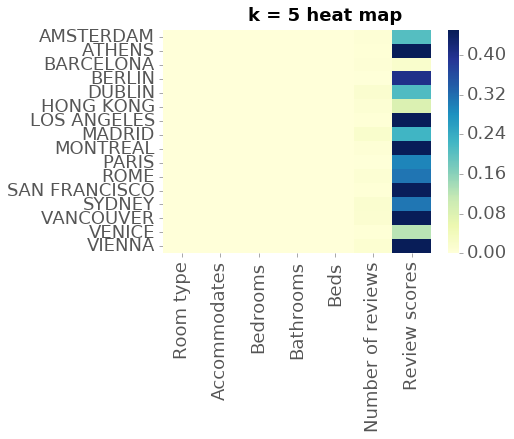

In [14]:
import pandas as pd
import numpy as np
from scipy.spatial import distance
import sys
import json
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns



df = pd.DataFrame.from_csv("heat_results.csv")

#load cities' information
with open('cities_dictionary.json') as json_data:
    cities_dict = json.load(json_data)

del cities_dict['EXAMPLE']

city_list = []
for key in cities_dict:
    city_list.append(key)
#print city_list

feature_cols = ["Room type", "Accommodates", "Bedrooms", "Bathrooms", "Beds", "Number of reviews", "Review scores"]

#print feature_cols

#print city_list

#print df.head(5)

#del df["Review scores"]
#del df["Number of reviews"]

df.sort_index(inplace=True)

values = []
for index, row in df.iterrows():
    row = row.tolist()
    values = values + row
#print values

plt.style.use('ggplot')

sns.heatmap(df, annot=False, cmap="YlGnBu", vmax = 0.45)
#vmax=0.0000000000000005
#vmin = 0.00000000000000000000011, vmax = 0.00000000000000011
plt.matplotlib.rcParams.update({'font.size': 18}, )
plt.suptitle("k = 5 heat map", fontsize=18, fontweight='bold')
rotation="vertical"
plt.show()

As we can see from the map, the code has selected all right features and determines the k=5 neighbours based on the review scores.

### Results

We determine the average money you can get in a month from each Airbnb city and compare it to a regular rent. Regular rent is taken from Numbeo. Occupancy rates from inise Airbnb. 

               Airbnb 1 day  Airbnb 1 month  Regular 1 month  Salary 1 month
SAN FRANCISCO           170            2142             2546            4450
VENICE                  109            1243              658            1309
AMSTERDAM               122            1171             1276            2345
DUBLIN                  118            1168             1324            2352
LOS ANGELES             125            1163             1510            3172
SYDNEY                  160             960             1569            3258
BARCELONA                87             861              748            1336
VANCOUVER                81             705             1090            2082
PARIS                    67             623              965            2320
VIENNA                   64             557              694            1880
BERLIN                   58             539              659            2053
HONG KONG                77             508             1514            2235

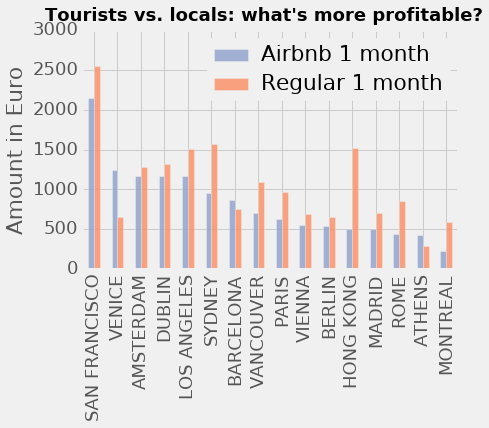

In [18]:
import pandas as pd
import numpy as np
from scipy.spatial import distance
import sys
import json
import matplotlib.pyplot as plt

df = pd.DataFrame.from_csv("city_results.csv")

df = df.sort_values('Airbnb 1 month', ascending = False)

x = np.arange(df.shape[0])

print df

plt.style.use('fivethirtyeight')
#plt.style.use('ggplot')

import brewer2mpl
bmap = brewer2mpl.get_map('Set2','qualitative',3 ,reverse=True)
colors = bmap.mpl_colors

ax = df.plot(x, y=["Airbnb 1 month", "Regular 1 month"], color=colors, alpha=0.8, kind="bar")
#ax.set_xticks(x + 0.4)
ax.set_xticklabels(list(df.index.values), rotation="vertical")

ax.set_ylabel('Amount in Euro')
plt.suptitle("Tourists vs. locals: what's more profitable?", fontsize=18, fontweight='bold')


plt.matplotlib.rcParams.update({'font.size': 18})

plt.show()

Concerning a small studio apartment, Airbnb is convenient in Venice, Barcelona and Athens. Regular rents are still more profitable in other cities. 